# Confeccion de la red en NetworkX

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
%pip install python-louvain

Note: you may need to restart the kernel to use updated packages.


## Leeremos desde el archvio para crear la red

In [7]:
    

# Especifica la ruta de tu archivo TSV
ruta_archivo = 'red_fenotipos_genes_dysgraphia.txt'

# Lee el archivo TSV y crea un grafo bipartito
    
df = pd.read_csv(ruta_archivo, sep='\t')

# Crea un grafo bipartito
G = nx.Graph()

# Agregar nodos y aristas al grafo bipartito
for _, row in df.iterrows():
    gene_symbol = row['gene_symbol']
    hpo_id = row['hpo_id']
    G.add_node(gene_symbol, bipartite=0)  # genes en la primera partición
    G.add_node(hpo_id, bipartite=1)       # HPO IDs en la segunda partición
    G.add_edge(gene_symbol, hpo_id)

    
    

In [105]:
df.head()

,ncbi_gene_id,gene_symbol,hpo_id,hpo_name,frequency,disease_id
0,10,NAT2,HP:0000007,Autosomal recessive inheritance,-,OMIM:243400
1,10,NAT2,HP:0001939,Abnormality of metabolism/homeostasis,-,OMIM:243400
2,16,AARS1,HP:0002460,Distal muscle weakness,15/15,OMIM:613287
3,16,AARS1,HP:0002451,Limb dystonia,3/3,OMIM:616339
4,16,AARS1,HP:0008619,Bilateral sensorineural hearing impairment,HP:0040283,ORPHA:33364


## Ahora crentraremos el grafo en el hp con lo nodos a dos pasos de el

Nos cerntraremos en el hpo, para crear un subgrafo.


In [9]:
target_hpo = 'HP:0010526'

# Calcular las longitudes de los caminos más cortos desde el nodo de interés
shortest_paths = nx.single_source_shortest_path_length(G, target_hpo)

# Filtrar nodos a 2 pasos o menos 
filtered_nodes2 = [node for node, distance in shortest_paths.items() if distance <= 2]

# Crear un subgrafo con los nodos filtrados
subgraph2 = G.subgraph(filtered_nodes2)



In [10]:
# Visualizar el subgrafo
pos2 = nx.spring_layout(subgraph2)
nx.draw(subgraph2, pos2, with_labels=True, node_size=10, font_size=8)
plt.savefig('grafo_bipartito.png', dpi=300)
plt.show()

KeyboardInterrupt: 

## proyeccion red de Hps

In [11]:
from networkx.algorithms import bipartite 

hpo_ids,genes  = bipartite.sets(subgraph2)

In [12]:
hpo_projection = nx.bipartite.projected_graph(subgraph2, hpo_ids )

In [13]:
pos2 = nx.spring_layout(hpo_projection)
nx.draw(hpo_projection, pos2, with_labels=True, node_size=10, font_size=8)
plt.savefig('grafo_bipartito.png', dpi=300)
plt.show()

KeyboardInterrupt: 

In [14]:
diametro = nx.diameter(hpo_projection)
diametro

2

In [71]:
import community 
# Ejemplo con el algoritmo Louvain
communities = community.best_partition(hpo_projection)




In [73]:
df_comunidades = pd.DataFrame(list(communities.items()), columns=['HPO_ID', 'Comunidad'])
df_comunidades

,HPO_ID,Comunidad
0,HP:0030521,0
1,HP:0011463,1
2,HP:0000787,2
3,HP:0001007,3
4,HP:0004374,0
...,...,...
1352,HP:0030257,0
1353,HP:0001265,1
1354,HP:0000105,0
1355,HP:0001287,2


In [65]:
comunidades_hpo_interes = df_comunidades[df_comunidades['HPO_ID'] == "HP:0010526"]['Comunidad'].values

for i in comunidades_hpo_interes: 
    print (i)

1


El hp de interes pertenece a la comunidad 1, vemamos que mas hps pertenecen a la comunidad 

In [4]:
hps_com1 = df_comunidades[df_comunidades['Comunidad'] == 1]['HPO_ID'].values

NameError: name 'df_comunidades' is not defined

In [115]:

# Calcular la centralidad de intermediación de los nodos HPO
hpo_betweenness = nx.betweenness_centrality(hpo_projection)

# Imprimir la centralidad de intermediación de los nodos HPO



In [119]:
datos_combinados = {key: {'Comunidad': communities[key], 'Centralidad': hpo_betweenness[key]} for key in communities}

# Convertir el diccionario combinado a un DataFrame
df_combinado = pd.DataFrame(list(datos_combinados.items()))

# Dividir el diccionario combinado en dos columnas: 'HPO_ID', 'Valores'
df_combinado[['HPO_ID', 'Comunidad_Centralidad']] = pd.DataFrame(df_combinado[1].tolist(), index=df_combinado.index)

# Eliminar la columna no necesaria
df_combinado = df_combinado.drop(1, axis=1)

df_combinado = df_combinado.rename(columns={0: 'HPO_ID','HPO_ID': 'Comunidad','Comunidad_Centralidad': 'Centralidad'})
df_combinado = df_combinado.sort_values(by='Centralidad', ascending=False)
# ademas uniremos tambine los nombres de las enfermedades 

# Anexar la columna 'hpo_name' al DataFrame combinado
df_resultado = pd.merge(df_combinado, df[['hpo_id', 'hpo_name']], left_on='HPO_ID', right_on='hpo_id', how='left')

# Eliminar la columna adicional 'hpo_ids' (si se desea)
df_resultado = df_resultado.drop('hpo_id', axis=1)
df_resultado = df_resultado.drop_duplicates(subset=['HPO_ID'])
df_resultado

,HPO_ID,Comunidad,Centralidad,hpo_name
0,HP:0010526,1,0.025288,Dysgraphia
67,HP:0001288,1,0.021121,Gait disturbance
573,HP:0001260,1,0.020320,Dysarthria
1341,HP:0000716,1,0.019448,Depression
1884,HP:0000006,1,0.018214,Autosomal dominant inheritance
...,...,...,...,...
185646,HP:0033725,1,0.000000,Thin corpus callosum
185754,HP:0001331,4,0.000000,Absent septum pellucidum
185826,HP:0000499,4,0.000000,Abnormal eyelash morphology
185877,HP:0031908,1,0.000000,Micrographia


Dentro de los genes relacionados directamente con disgrapihia, hay alguno genes que tienen mas centralidad qeu otros, es decir, estan conectados a mas hpo. Es decir , podriamos inferir que los que tinen menos centralidad (estando concectados por uno a dysgraphia) son mas especificos afectando casi solo a dysgraphia 
- (hipotesis) - podrian ser targets en terapia genica, sileciandolos podrian mitigar la disgrafia???

In [ ]:
# Calcular el grado de los nodos HPO en la proyección
hpo_grados = hpo_projection.degree(hpo_ids)

# Imprimir los grados de los nodos HPO
print("Grados de los nodos HPO:", hpo_grados)


## proyeccion red de Genes

In [33]:
gene_projection = nx.bipartite.projected_graph(subgraph2, genes )

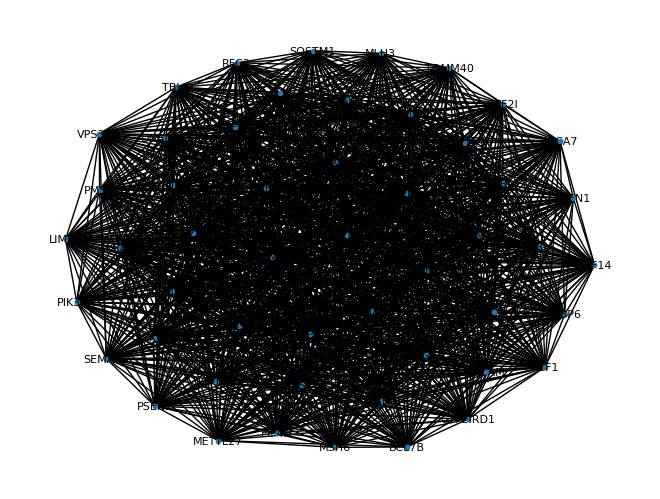

In [36]:
pos2 = nx.spring_layout(gene_projection)
nx.draw(gene_projection, pos2, with_labels=True, node_size=10, font_size=8)
plt.savefig('grafo_bipartito.png', dpi=300)
plt.show()

In [26]:
diametro = nx.diameter(gene_projection)
diametro

1

## Hpos altamente relacionados con la dysgraphia 

In [26]:

print(len(lista_de_nodos))
if len(hpo_projection) == len(set(hpo_projection)):
    print("No hay elementos repetidos.")
else:
    print("Hay elementos repetidos.")

1357
No hay elementos repetidos.


parece que, el propio grafo no permite que dos hpos esten relacionados por mas de un gen. 


In [70]:
#usamos la lista de nodos (que son los nodos a un paso del hpo , sacada de la pryeccion de hpos) y l
lista_de_nodos = list(hpo_projection.nodes())
df_un_paso=df[df['hpo_id'].isin(lista_de_nodos)]
print(len(df_un_paso))
df_un_paso=df_un_paso[df['gene_symbol'].isin(gene_projection.nodes())]
print(len(df_un_paso))

185912
8270


/var/folders/76/mxbv2rc56k12dg4mcx60_c5h0000gn/T/ipykernel_1858/1899259282.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_un_paso=df_un_paso[df['gene_symbol'].isin(gene_projection.nodes())]


In [73]:
## 
hpos_disg_df=df[df['hpo_id']=="HP:0010526"]
df_un_paso['frequency'] = df_un_paso.groupby('hpo_id')['hpo_id'].transform('count')



los uqe mas relacionados , (los que ma entradas tengan )

In [75]:

df_un_paso.to_csv('nombre_archivo.csv', index=False)
